In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [5]:
plt.rcParams['figure.figsize'] = (15, 8)

In [7]:
base_db = pd.read_csv("use_db_sabato14.csv")

# Repeated experiments

**Considering only the top case duration experiments**

In [8]:
base_db.obs_duration_mean.value_counts()

96.0     22305
24.0     11322
48.0      9349
72.0      2799
6.0        892
         ...  
27.5         1
167.5        1
58.5         1
70.8         1
298.0        1
Name: obs_duration_mean, Length: 262, dtype: int64

In [9]:
base_db = base_db[base_db.obs_duration_mean.isin([96, 24, 48, 72])]
base_db.index.size

45775

In [24]:
c_exp = base_db.groupby(["test_cas", "species", "obs_duration_mean", "conc1_type", "exposure_type"])\
                .agg(Median=('conc1_mean', 'median'), Count=('conc1_mean', 'count'), Std=('conc1_mean', "std"))
c_exp = c_exp[c_exp.Count>1]
c_exp

Median  \
test_cas species     obs_duration_mean conc1_type exposure_type            
100-01-6 promelas    96.0              A          F              125.000   
                                                  S              103.950   
100-02-7 macrochirus 96.0              A          S                8.300   
         mykiss      96.0              A          S                5.945   
         promelas    96.0              A          F               41.000   
...                                                                  ...   
99-65-0  promelas    96.0              A          S               15.900   
99-97-8  promelas    96.0              A          F               49.000   
999-61-1 promelas    96.0              A          F                3.355   
999-81-5 macrochirus 96.0              A          S              550.000   
         mykiss      96.0              A          S              550.000   

                                                                 Count  \
test_cas species     obs_duration_mean conc1_type exposure_type          
100-01-6 promelas    96.0              A          F                  2   
                                                  S                  2   
100-02-7 macrochirus 96.0              A          S                  3   
         mykiss      96.0              A          S                  6   
         promelas    96.0              A          F                  9   
...                                                                ...   
99-65-0  promelas    96.0              A          S                  3   
99-97-8  promelas    96.0              A          F                  2   
999-61-1 promelas    96.0              A          F                  4   
999-81-5 macrochirus 96.0              A          S                  2   
         mykiss      96.0              A          S                  2   

                                                                        Std  
test_cas species     obs_duration_mean conc1_type exposure_type              
100-01-6 promelas    96.0              A          F                0.000000  
                                                  S                3.040559  
100-02-7 macrochirus 96.0              A          S                8.443341  
         mykiss      96.0              A          S               29.692050  
         promelas    96.0              A          F               12.575671  
...                                                                     ...  
99-65-0  promelas    96.0              A          S                5.416949  
99-97-8  promelas    96.0              A          F                4.242641  
999-61-1 promelas    96.0              A          F                0.294449  
999-81-5 macrochirus 96.0              A          S              636.396103  
         mykiss      96.0              A          S              636.396103  

[7236 rows x 3 columns]

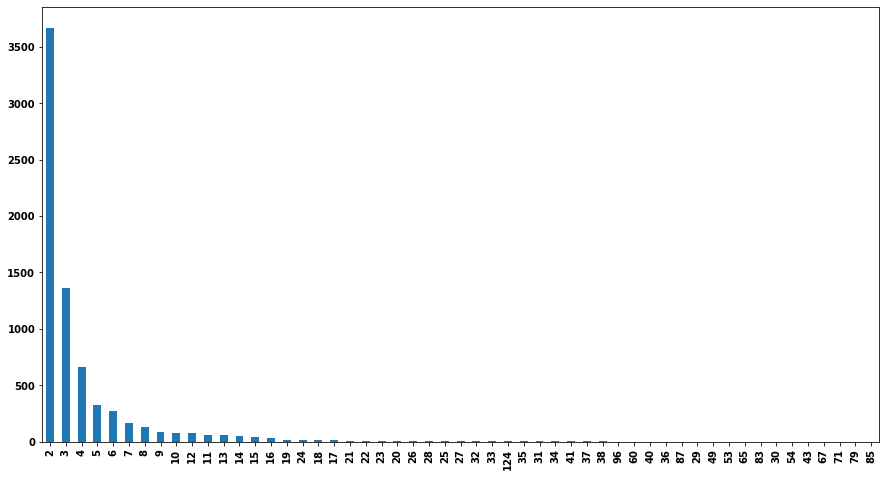

In [60]:
c_exp.Count.value_counts().plot(kind="bar")

In [82]:
c_exp[c_exp.Count>120]

,,,,,Median,Count,Std
test_cas,species,obs_duration_mean,conc1_type,exposure_type,,,
12125-02-9,mykiss,96.0,T,F,27.40000,124,23.920016
7761-88-8,promelas,96.0,T,S,0.00903,124,0.032926


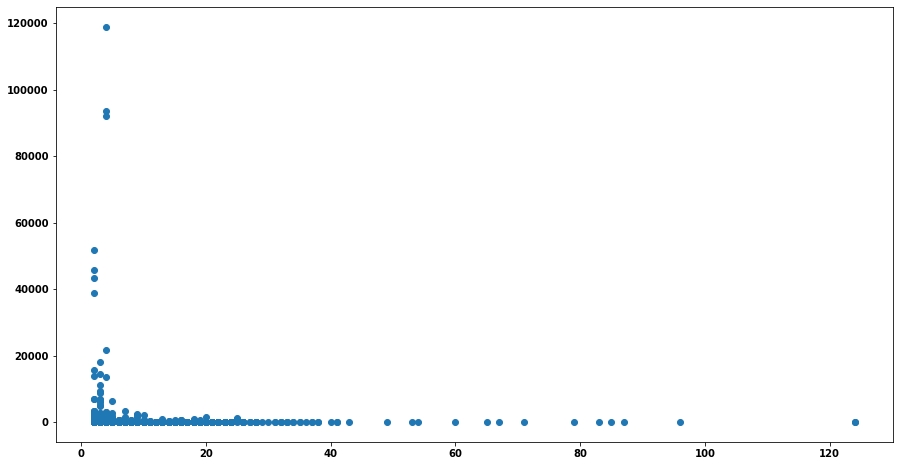

In [83]:
plt.scatter(x=c_exp.Count, y=c_exp.Std)
#plt.xlim(1.5, 10.5)
#plt.ylim(-10,1000)

(-10, 1000)

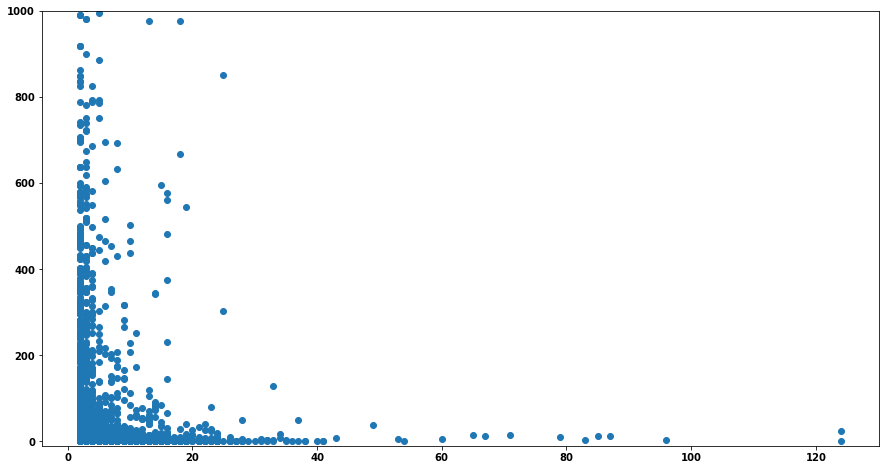

In [80]:
plt.scatter(x=c_exp.Count, y=c_exp.Std)
#plt.xlim(1.5, 10.5)
plt.ylim(-10,1000)

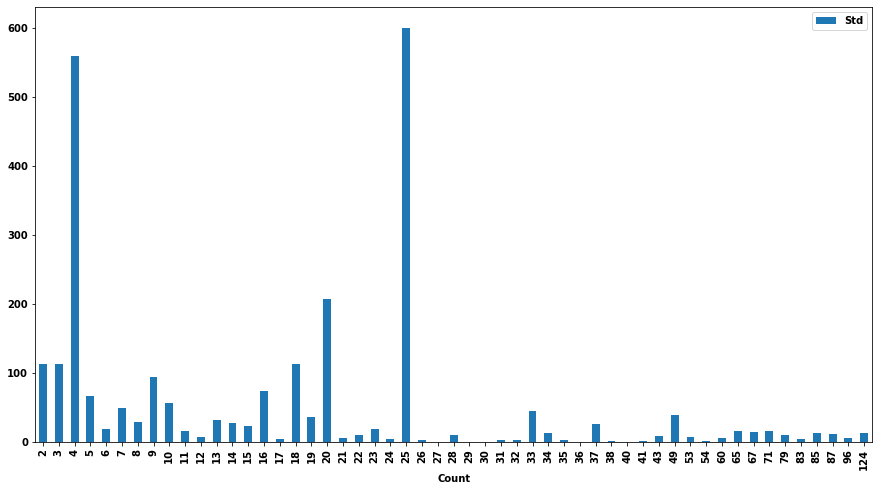

In [91]:
c_exp.groupby("Count").agg(Std=("Std","mean")).plot(kind="bar")

In [52]:
count_good = base_db.copy()
count_good["killed"] =  np.where(count_good['conc1_mean']>=1, 1, 0)
count_good = count_good.groupby(["test_cas", "species", "obs_duration_mean", "conc1_type", "exposure_type"])\
                .agg(Median=('conc1_mean', 'median'), Count=('conc1_mean', 'count'), Std=('conc1_mean', "std"), tot_kill=('killed', 'sum'))
#count_good = count_good[count_good.Count>1]
count_good['acc'] = count_good.tot_kill/count_good.Count
bad_exp = count_good[(count_good.acc<1) & (count_good.acc!=0)]

In [53]:
bad_exp

Median  \
test_cas   species      obs_duration_mean conc1_type exposure_type           
10099-74-8 arcticus     96.0              T          S               6.850   
           carpio       96.0              D          S               1.405   
                                          T          R               0.620   
           catla        96.0              D          S               1.115   
           mykiss       96.0              D          S               1.380   
...                                                                    ...   
96300-97-9 mykiss       96.0              A          S               1.500   
                                          F          S               2.700   
97-17-6    heteromorpha 24.0              F          R               1.525   
99-30-9    mykiss       96.0              A          S               1.080   
99-35-4    promelas     96.0              A          S               0.795   

                                                                    Count  \
test_cas   species      obs_duration_mean conc1_type exposure_type          
10099-74-8 arcticus     96.0              T          S                  6   
           carpio       96.0              D          S                 14   
                                          T          R                  4   
           catla        96.0              D          S                 14   
           mykiss       96.0              D          S                  7   
...                                                                   ...   
96300-97-9 mykiss       96.0              A          S                  9   
                                          F          S                  2   
97-17-6    heteromorpha 24.0              F          R                  2   
99-30-9    mykiss       96.0              A          S                  2   
99-35-4    promelas     96.0              A          S                  2   

                                                                          Std  \
test_cas   species      obs_duration_mean conc1_type exposure_type              
10099-74-8 arcticus     96.0              T          S              17.192512   
           carpio       96.0              D          S               0.798423   
                                          T          R               0.467126   
           catla        96.0              D          S               0.575500   
           mykiss       96.0              D          S               0.417481   
...                                                                       ...   
96300-97-9 mykiss       96.0              A          S               0.766975   
                                          F          S               2.545584   
97-17-6    heteromorpha 24.0              F          R               0.813173   
99-30-9    mykiss       96.0              A          S               0.735391   
99-35-4    promelas     96.0              A          S               0.431335   

                                                                    tot_kill  \
test_cas   species      obs_duration_mean conc1_type exposure_type             
10099-74-8 arcticus     96.0              T          S                     5   
           carpio       96.0              D          S                    10   
                                          T          R                     1   
           catla        96.0              D          S                     9   
           mykiss       96.0              D          S                     6   
...                                                                      ...   
96300-97-9 mykiss       96.0              A          S                     6   
                                          F          S                     1   
97-17-6    heteromorpha 24.0              F          R                     1   
99-30-9    mykiss       96.0              A          S                     1   
99-35-4    promelas     96.0         

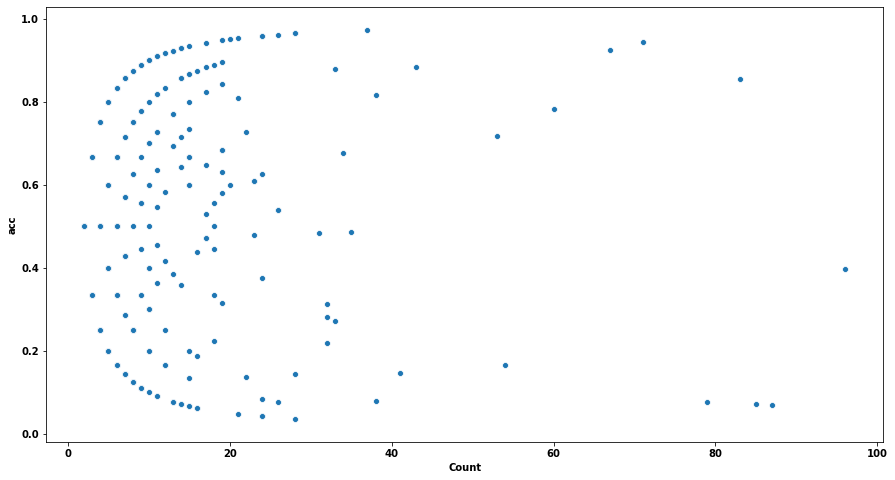

In [50]:
import seaborn as sns
sns.scatterplot(x=bad_exp.Count, y=bad_exp.acc)

In [54]:
bad_exp.acc.mean()

0.5181849810417137

In [55]:
count_good.acc.mean()

0.6351219976061239

In [28]:
grouped_std = base_db.groupby(["obs_duration_mean", "test_cas", "species"]).std().dropna().reset_index()

In [53]:
grouped_96h = grouped_std[grouped_std.obs_duration_mean==96]
grouped_96h.conc1_mean.sort_values(ascending=False)

6831    353482.679915
5093     53103.719267
4358     27734.305472
5017     21791.676801
4513     15563.420254
            ...      
7777         0.000000
4860         0.000000
6923         0.000000
5270         0.000000
5816         0.000000
Name: conc1_mean, Length: 3638, dtype: float64

In [36]:
grouped_std.loc[6831]

obs_duration_mean             96
test_cas                 8012951
species              macrochirus
conc1_mean                353483
Name: 6831, dtype: object

In [38]:
base_db[(base_db.obs_duration_mean==96) & (base_db.test_cas==8012951) & (base_db.species=="macrochirus")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
21857,8012951,S,96.0,A,500000.0,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NC,0.34 g,"Fish,Standard Test Species"
52635,8012951,S,96.0,A,100.0,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NC,0.46 g,"Fish,Standard Test Species"


In [ ]:
results_final= pd.read_pickle("data/results_final.pkl")

In [48]:
t = results_final[(results_final.test_cas==8012951) & (results_final.species=="macrochirus")]
t[["conc1_mean", "conc1_unit"]]

,conc1_mean,conc1_unit
25061,500000,ppm
36634,100,ppm
60143,100,ppm


In [39]:
grouped_std.loc[5093]

obs_duration_mean          96
test_cas               111466
species              promelas
conc1_mean            53103.7
Name: 5093, dtype: object

In [41]:
base_db[(base_db.obs_duration_mean==96) & (base_db.test_cas==111466) & (base_db.species=="promelas")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
18579,111466,S,96.0,F,100.0,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,NR,NR,"Fish,Standard Test Species"
51119,111466,F,96.0,A,75200.0,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,NR,"19.1 MM, 0.102 G","Fish,Standard Test Species"


In [45]:
t1 = results_final[(results_final.test_cas==111466) & (results_final.species=="promelas")]
t1[["conc1_mean", "conc1_unit"]]

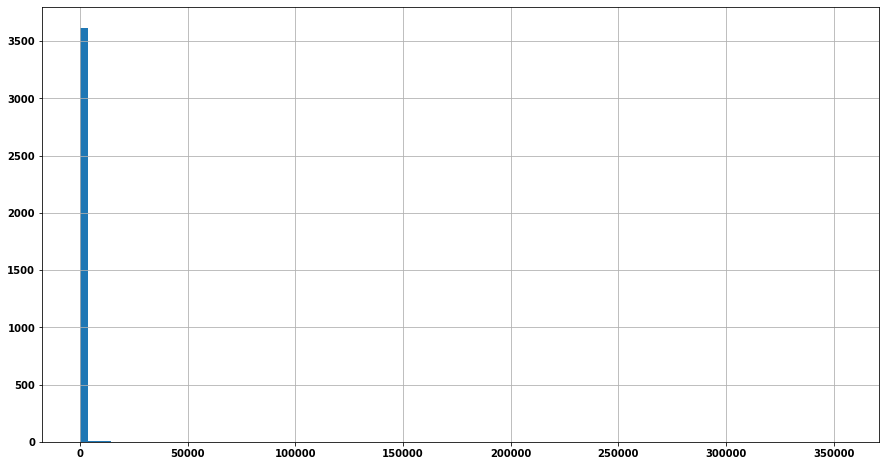

In [54]:
grouped_96h.conc1_mean.hist(bins=100)

In [69]:
grouped_96h.index.size

3638

In [68]:
grouped96h_no_out = grouped_96h[~(grouped_96h.conc1_mean>1000)]
grouped96h_no_out.index.size

3577

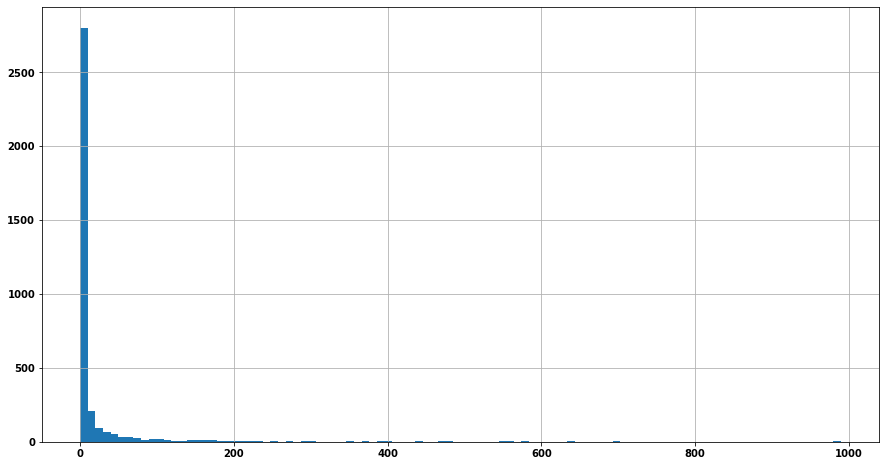

In [66]:
grouped96h_no_out.conc1_mean.hist(bins=100)

In [67]:
grouped96h_no_out[grouped96h_no_out.conc1_mean<10]

,obs_duration_mean,test_cas,species,conc1_mean
4227,96.0,50000,carolinus,2.909181
4228,96.0,50000,macrochirus,0.919239
4230,96.0,50000,promelas,1.171893
4231,96.0,50000,punctatus,0.000000
4234,96.0,50282,marmoratus,2.573869
...,...,...,...,...
7857,96.0,177256698,tshawytscha,0.000000
7858,96.0,187166401,macrochirus,0.951766
7860,96.0,243973208,promelas,0.000000
7861,96.0,243973208,variegatus,0.000000


In [70]:
grouped_24h = grouped_std[grouped_std.obs_duration_mean==24]
grouped_24h.conc1_mean.sort_values(ascending=False)

524     118952.849066
518      29965.980711
104      18738.329701
230      18027.756377
220      10487.769067
            ...      
1689         0.000000
867          0.000000
1765         0.000000
1459         0.000000
1193         0.000000
Name: conc1_mean, Length: 1891, dtype: float64

In [71]:
grouped_std.loc[524]

obs_duration_mean             24
test_cas                  108872
species              crysoleucas
conc1_mean                118953
Name: 524, dtype: object

In [72]:
base_db[(base_db.obs_duration_mean==24) & (base_db.test_cas==108872) & (base_db.species=="crysoleucas")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
737,108872,S,24.0,F,238000.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish
3504,108872,S,24.0,F,62.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish
3530,108872,S,24.0,F,180.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish
25760,108872,S,24.0,F,41.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish


In [77]:
t2 = results_final[(results_final.obs_duration_mean=="24") & (results_final.test_cas==108872) & (results_final.species=="crysoleucas")]
t2[["conc1_mean", "conc1_unit"]]

,conc1_mean,conc1_unit
892,238000000*,ug/L
4098,62000*,ug/L
4125,180000*,ug/L
29491,41000*,ug/L


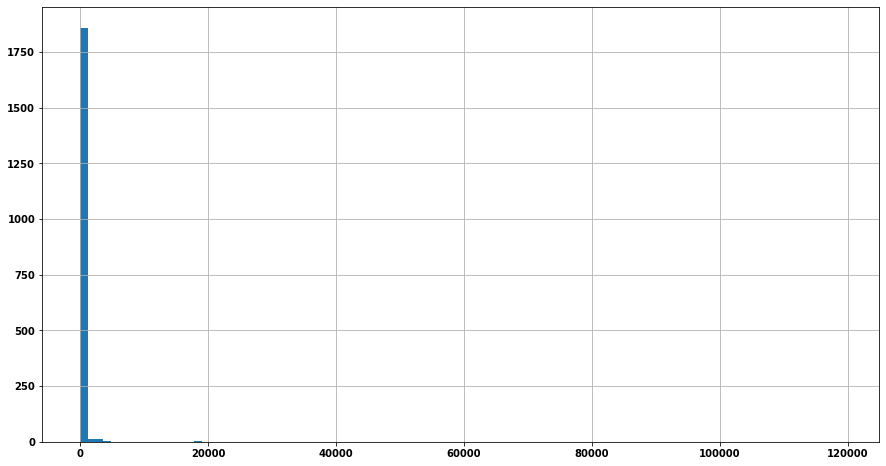

In [78]:
grouped_24h.conc1_mean.hist(bins=100)

In [80]:
grouped_24h.index.size

1891

In [83]:
grouped_24h[~(grouped_24h.conc1_mean>1000)]

,obs_duration_mean,test_cas,species,conc1_mean
0,24.0,50000,carolinus,3.579572
1,24.0,50000,latipes,27.300794
2,24.0,50000,mykiss,30.405592
3,24.0,50000,punctatus,28.867513
4,24.0,50000,saxatilis,44.353880
...,...,...,...,...
1886,24.0,96352691,mykiss,0.000000
1887,24.0,100473083,macrochirus,0.611010
1888,24.0,100473083,mykiss,0.707107
1889,24.0,107534963,rerio,12.586501
